# Base Model

- Train: 75Agree_train
- Test: 75Agree_test

### Step 1: Prepate the data to feed the model

In [ ]:
import pandas as pd

# load the training and test datasets
df_train = pd.read_csv('data/75Agree_train.csv')
df_test = pd.read_csv('data/75Agree_test.csv')

# label encoders
label2id = {"negative": 0, "neutral": 1, "positive": 2}
id2label = {v: k for k, v in label2id.items()}

# label encoding
df_train["label"] = df_train["label"].map(label2id)
df_test["label"] = df_test["label"].map(label2id)

# balance the training set: undersample to minority class
df_train = df_train.groupby("label").apply(lambda x: x.sample(df_train["label"].value_counts().min())).reset_index(drop=True)
df_train.value_counts("label")

### Step 2: The model

In [ ]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize_function(examples):
    return tokenizer(examples["sentence"], truncation=True, padding="max_length", max_length=128)

# prepare for cv
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logs = {}

for fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train["label"])):
    # get the folds
    df_fold_train = df_train.iloc[train_idx]
    df_fold_val = df_train.iloc[val_idx]

    # dataset preparation for huggingface transformers
    train_dataset = Dataset.from_pandas(df_fold_train)
    val_dataset = Dataset.from_pandas(df_fold_val)

    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)

    train_dataset = train_dataset.rename_column("label", "labels")
    val_dataset = val_dataset.rename_column("label", "labels")

    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    # the model
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3, id2label=id2label, label2id=label2id)

    training_args = TrainingArguments(
        num_train_epochs=4,
        learning_rate=2e-5,
        weight_decay=0.01,
        eval_strategy="steps",
        eval_steps=25,
        logging_strategy="steps",
        logging_steps=25,
        report_to=None,
        dataloader_pin_memory=False,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        save_total_limit=1,
        save_steps=500,
        output_dir=f"./results/fold_{fold}",
        disable_tqdm=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
    )

    print(f"Training fold {fold}...")
    trainer.train()

    logs[fold] = trainer.state.log_history

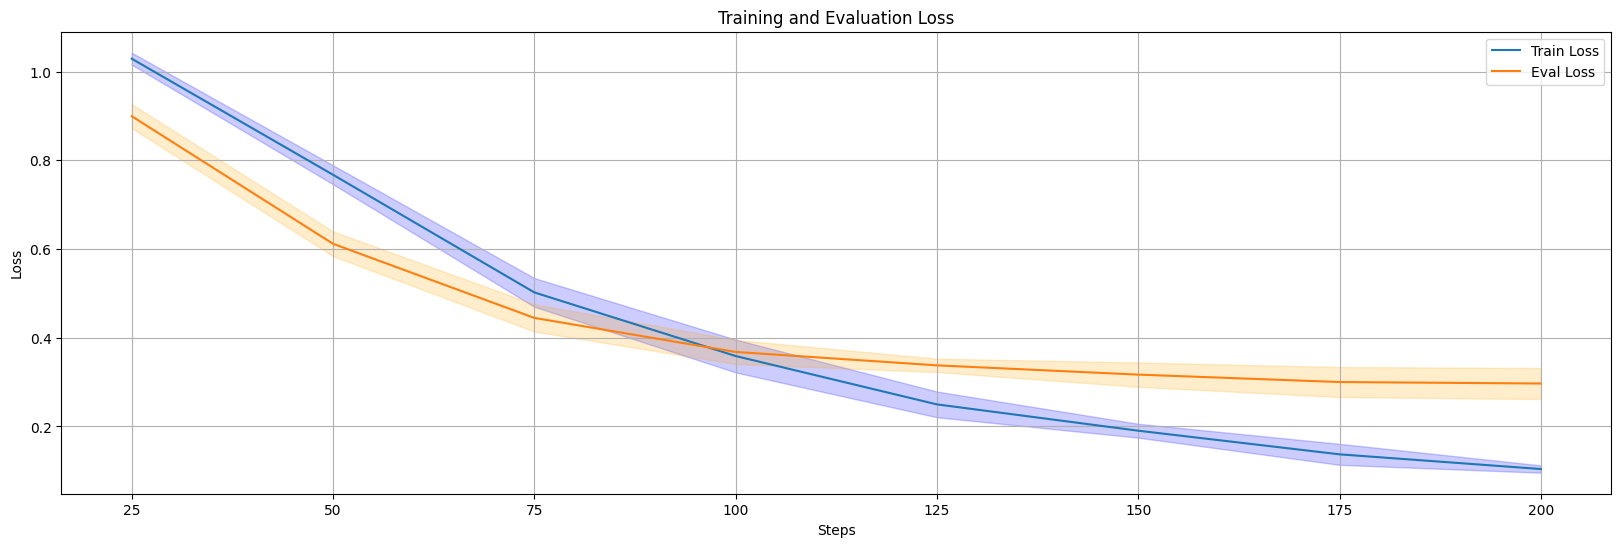

In [54]:
import matplotlib.pyplot as plt

train_losses = []
eval_losses = []
train_steps = []
eval_steps = []
for fold in logs:
    log_history = logs[fold]
    train_losses.append([x["loss"] for x in log_history if "loss" in x])
    eval_losses.append([x["eval_loss"] for x in log_history if "eval_loss" in x])
    train_steps.append([x["step"] for x in log_history if "loss" in x])
    eval_steps.append([x["step"] for x in log_history if "eval_loss" in x])

# get mean and std for train and eval losses
train_losses = np.array(train_losses)
train_loss = np.mean(train_losses, axis=0)
train_loss_std = np.std(train_losses, axis=0)

eval_losses = np.array(eval_losses)
eval_loss = np.mean(eval_losses, axis=0)
eval_loss_std = np.std(eval_losses, axis=0)
    
# make sure train_steps and eval_steps sublists are equal
if all(steps == train_steps[0] for steps in train_steps):
    train_steps = train_steps[0]
else:
    raise ValueError("Train steps are not consistent across folds.")

if all(steps == eval_steps[0] for steps in eval_steps):
    eval_steps = eval_steps[0]
else:
    raise ValueError("Eval steps are not consistent across folds.")

# draw the training and evaluation losses
plt.figure(figsize=(20, 6))
plt.plot(train_steps, train_loss, label="Train Loss")
plt.plot(eval_steps, eval_loss, label="Eval Loss")
plt.fill_between(train_steps, train_loss - train_loss_std, train_loss + train_loss_std, alpha=0.2, color='blue')
plt.fill_between(eval_steps, eval_loss - eval_loss_std, eval_loss + eval_loss_std, alpha=0.2, color='orange')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.show()

---
---
---
# TO BE DONE YET FOR THE CV

### Step 3: Evaluate the model

In [ ]:
"""train_dataset = Dataset.from_pandas(df_fold_train)
val_dataset = Dataset.from_pandas(df_fold_val)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("label", "labels")
val_dataset = val_dataset.rename_column("label", "labels")

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])"""

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_dataset(dataset, split_name):
    output = trainer.predict(dataset)
    preds = np.argmax(output.predictions, axis=1)
    y_true = output.label_ids

    print(f"\n=== Classification Report ({split_name}) ===")
    print(classification_report(y_true, preds, target_names=["negative", "neutral", "positive"]))

    cm = confusion_matrix(y_true, preds, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=["negative", "neutral", "positive"],
                yticklabels=["negative", "neutral", "positive"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Normalized Confusion Matrix ({split_name})")
    plt.show()

# evaluate the model on the training and test datasets
evaluate_dataset(train_dataset, "Train")
evaluate_dataset(test_dataset, "Test")